In [ ]:
! pip install datasets
! pip install -U transformers
! pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import numpy as np

# Load the training dataset and the testing dataset
data_file_train = load_dataset("maykcaldas/smiles-transformers", split='train', streaming=True)
data_file_test = load_dataset("maykcaldas/smiles-transformers", split='test', streaming=True)

# Shuffle before selecting the first 1K rows of data to create a random sample
#data_train = data_file_train.shuffle(seed=2023, buffer_size=1000)
#data_test = data_file_test.shuffle(seed=2023, buffer_size=1000)
data_train = data_file_train.shuffle(seed=2023)
data_test = data_file_test.shuffle(seed=2023)

# Create a iterator to process the data
#small_train = [next(dataset_iter) for _ in range(10000)]
#small_test = [next(dataset_iter) for _ in range(10001, 11001)]
dataset_train_iter = iter(data_file_train)
dataset_test_iter = iter(data_file_test)

# Train on a smaller sample for better efficiency
# Training on the whole dataset will take days and large CU
small_train = [next(dataset_train_iter) for _ in range(100000)]
small_test = [next(dataset_test_iter) for _ in range(10000)]

Resolving data files:   0%|          | 0/273 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/273 [00:00<?, ?it/s]

In [ ]:
from datasets import Dataset
# New smaller dataset for the selected dict
dataset_small_train = Dataset.from_dict({k: [dic[k] for dic in small_train] for k in small_train[0]})
dataset_small_test = Dataset.from_dict({k: [dic[k] for dic in small_test] for k in small_test[0]})

In [ ]:
import pandas as pd

# Data processing
def preprocess_data(examples):
    # Label is RingCount, the property we want to predict
    # Handle the NaN values in 'RingCount' by substituting them with 0
    labels = np.where(pd.isna(examples['RingCount']), 0, examples['RingCount'])

    return {
        'input_ids': tokenizer(examples["text"], padding="max_length", truncation=True)['input_ids'],
        'labels': labels
    }

# Tokenize the data
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
# Remove unused columns to save training resources
tokenized_small_train = dataset_small_train.map(preprocess_data, batched=True, remove_columns=['formula', 'NumHDonors', 'NumHAcceptors', 'MolLogP', 'NumHeteroatoms', 'NumRotatableBonds', 'NumAromaticBonds', 'NumAcidGroups', 'NumBasicGroups', 'Apol'])
tokenized_small_test = dataset_small_test.map(preprocess_data, batched=True, remove_columns=['formula', 'NumHDonors', 'NumHAcceptors', 'MolLogP', 'NumHeteroatoms', 'NumRotatableBonds', 'NumAromaticBonds', 'NumAcidGroups', 'NumBasicGroups', 'Apol'])
#tokenized_small_train = dataset_small_train.map(preprocess_data, batched=True)
#tokenized_small_test = dataset_small_test.map(preprocess_data, batched=True)

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

<Axes: ylabel='Frequency'>

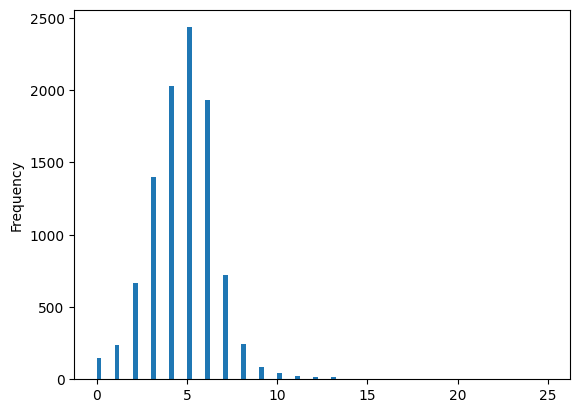

In [ ]:
tokenized_small_test.to_pandas().head(10)
# Plot to see the distribution of label values
tokenized_small_test.to_pandas()['labels'].plot.hist(bins=100)

In [ ]:
# The number of label types is the max_value in labels
df = tokenized_small_train.to_pandas()
max_value = df['labels'].max()
max_value

40

In [ ]:
from transformers import EarlyStoppingCallback
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=max_value+1)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=64,  # Adjusted batch size
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end = True,
    learning_rate=1e-5,  # adjusted learning rate
    weight_decay=0.01,  # ajusted weight decay
    lr_scheduler_type="linear"  # adjusted learning rate scheduler type
)

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train,
    eval_dataset=tokenized_small_test,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,1.105700,0.824858
2,0.591800,0.385461
3,0.401300,0.309520
4,0.311400,0.360001
5,0.261000,0.320899
6,0.229800,0.326693


TrainOutput(global_step=9378, training_loss=0.6091446090441163, metrics={'train_runtime': 1698.4019, 'train_samples_per_second': 588.789, 'train_steps_per_second': 9.203, 'total_flos': 5556660019200000.0, 'train_loss': 0.6091446090441163, 'epoch': 6.0})

In [ ]:
# Using the SMILES from task 2
smiles_list = [
    "C1=CC=CC=C1",
    "CN1C=CC2=C1C(=O)N(C(=O)N2C)C",
    "CC12CCC3C(C1CCC2O)CCC4=C3C=CC(=C4)C"
]

def predict_property(smiles, model, device):
    # Tokenize and move the input to the correct device
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True).to(device)

    # Inference with model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits and calculate the most possible label
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=-1)

    # Move the predicted label to CPU and convert Python value
    return predicted_label.cpu().item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

# Predict RingCount for every smiles
predicted_properties = [predict_property(smiles, model, device) for smiles in smiles_list]
print(predicted_properties)

Using device: cuda
[7, 7, 3]
